## Working with WRF NetCDF Files

This example notebook shows how to use `xarray` and `rioxarray` libraries to convert Weather Research and Forecasting Model (WRF) NetCDF files to GeoTIFF files.

References
- [WRF data and Xarray](https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/WRF/wrf_ex.html)
- [GIS4WRF](https://github.com/GIS4WRF/gis4wrf/)

In [17]:
import os
import xarray as xr
import rioxarray as rxr
from osgeo import osr, ogr
from affine import Affine
import rasterio

In [18]:
file_name = 'wrfout_20221211_12.nc'
file_path = os.path.join('data', file_name)

In [19]:
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 299, west_east: 299,
                            bottom_top: 35, bottom_top_stag: 36,
                            soil_layers_stag: 4, west_east_stag: 300,
                            south_north_stag: 300, seed_dim_stag: 8,
                            num_turb_layers: 7)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag,
                                seed_dim_stag, num_turb_layers
Data variables: (12/253)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2022-12-09_12:00:00
    SIMULATION_START_DATE:           2022-12-09_12:00:00
    WEST-EAST_GRID_DIMENSION:        300
    SOUTH-NORTH_GRID_DIMENSION:      300
    BOTTOM-TOP_GRID_DIMENSION:       36
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

Select 'T2' variable and convert from K to C.

In [20]:
da = ds.T2.sel(Time=0) -273.15

We pre-process the data to match CF conventions.

In [21]:
da_with_latlon = da.assign_coords(lat=da.coords['XLAT'], lon=da.coords['XLONG'])
da_with_latlon_rename = da_with_latlon.rename({'south_north':'y', 'west_east':'x'})
da_with_latlon_drop = da_with_latlon_rename.drop(['XLAT', 'XLONG', 'XTIME'])
da_wrf_cf = da_with_latlon_drop

In [22]:
da_wrf_cf

<xarray.DataArray 'T2' (y: 299, x: 299)>
array([[24.988586, 24.995941, 24.98938 , ..., 24.238098, 24.39441 ,
        24.465973],
       [24.998016, 24.975922, 24.946411, ..., 24.205078, 24.348206,
        24.480438],
       [24.987885, 24.968018, 24.917847, ..., 24.132355, 24.332092,
        24.46167 ],
       ...,
       [24.696686, 24.733307, 24.769958, ..., 22.910309, 22.873535,
        22.919525],
       [24.678864, 24.719208, 24.76773 , ..., 22.932556, 22.871765,
        22.88565 ],
       [24.64627 , 24.688324, 24.740234, ..., 23.005432, 22.941345,
        22.857056]], dtype=float32)
Coordinates:
    lat      (y, x) float32 4.8 4.8 4.8 4.8 4.8 ... 25.81 25.81 25.81 25.81
    lon      (y, x) float32 -94.28 -94.21 -94.14 -94.06 ... -72.51 -72.43 -72.36
Dimensions without coordinates: y, x

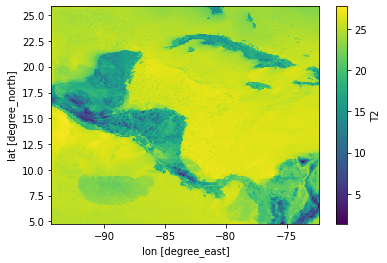

In [23]:
da_wrf_cf.plot(x='lon', y='lat')

To convert the data into a geoereferenced raster, we need to assign it a projection and a transform

WRF datasets store the projection in a dataset attribute named MAP_PROJ. The value is a numeric value that is associated with a different projection. 

```
LAMBERT_CONFORMAL = 1
POLAR_STEREOGRAPHIC = 2
MERCATOR = 3
LAT_LON = 6
```

In [24]:
ds.attrs['MAP_PROJ']

3

This dataset's projection is Mercator, so we extract the parameters required to construct the projection string. The CRS definitions come from [here](https://github.com/GIS4WRF/gis4wrf/blob/master/gis4wrf/core/crs.py).

In [25]:
truelat1 = ds.attrs['TRUELAT1']
origin_lon = ds.attrs['STAND_LON']
truelat1 = 41.602
origin_lon = 2.403
proj_str = ('+proj=merc +lat_ts={lat1} +lon_0={lon0} +x_0=0 +y_0=0 +datum=WGS84').format(
                 lat1=truelat1, lon0=origin_lon)
proj_str

'+proj=merc +lat_ts=41.602 +lon_0=2.403 +x_0=0 +y_0=0 +datum=WGS84'

We have to now compute a transform.

In [26]:
lons_u = ds.XLONG
lons_v = ds.XLONG
lats_u = ds.XLAT
lats_v = ds.XLAT

dim_x = ds.west_east.size
dim_y = ds.south_north.size

lower_left_u = float(lons_u[0,0,0]), float(lats_u[0,0,0])
lower_right_u = float(lons_u[0,0,-1]), float(lats_u[0,0,-1])
lower_left_v = float(lons_v[0,0,0]), float(lats_v[0,0,0])
upper_left_v = float(lons_v[0,-1,0]), float(lats_v[0,-1,0])



def transform_point(point):
    point_geom = ogr.Geometry(ogr.wkbPoint)
    point_geom.AddPoint(point[0], point[1])
    srs_in = osr.SpatialReference()
    srs_in.ImportFromProj4('+proj=latlong +datum=WGS84')
    srs_out = osr.SpatialReference()
    srs_out.ImportFromProj4(proj_str)
    transform = osr.CoordinateTransformation(srs_in, srs_out)
    point_geom.Transform(transform)
    return point_geom.GetX(), point_geom.GetY()

lower_left_u_xy = transform_point(lower_left_u)
lower_right_u_xy = transform_point(lower_right_u)
lower_left_v_xy = transform_point(lower_left_v)
upper_left_v_xy = transform_point(upper_left_v)

dx = (lower_right_u_xy[0] - lower_left_u_xy[0])/dim_x
dy = (upper_left_v_xy[1] - lower_left_v_xy[1])/dim_y
dx, dy

gdal_transform = (lower_left_u_xy[0], dx, 0, lower_left_v_xy[1], 0, dy)
transform = Affine.from_gdal(*gdal_transform)
transform

Affine(6112.2011415137, 0.0, -8060221.463898032,
       0.0, 6074.572060876764, 397960.1596466572)

Apply the transform and CRS.

In [27]:
da_wrf_cf.rio.write_crs(rasterio.crs.CRS().from_proj4(proj_str), inplace=True)
da_wrf_cf.rio.write_transform(transform, inplace=True)

<xarray.DataArray 'T2' (y: 299, x: 299)>
array([[24.988586, 24.995941, 24.98938 , ..., 24.238098, 24.39441 ,
        24.465973],
       [24.998016, 24.975922, 24.946411, ..., 24.205078, 24.348206,
        24.480438],
       [24.987885, 24.968018, 24.917847, ..., 24.132355, 24.332092,
        24.46167 ],
       ...,
       [24.696686, 24.733307, 24.769958, ..., 22.910309, 22.873535,
        22.919525],
       [24.678864, 24.719208, 24.76773 , ..., 22.932556, 22.871765,
        22.88565 ],
       [24.64627 , 24.688324, 24.740234, ..., 23.005432, 22.941345,
        22.857056]], dtype=float32)
Coordinates:
    lat          (y, x) float32 4.8 4.8 4.8 4.8 4.8 ... 25.81 25.81 25.81 25.81
    lon          (y, x) float32 -94.28 -94.21 -94.14 ... -72.51 -72.43 -72.36
    spatial_ref  int64 0
Dimensions without coordinates: y, x

We now have a array with correct CRS and transform. We drop existing coordinates and reproject it to EPSG:4326

In [28]:
da_wrf_cf_reprojected = da_wrf_cf.drop(['lat', 'lon']).rio.reproject('epsg:4326')
da_wrf_cf_reprojected

<xarray.DataArray 'T2' (y: 293, x: 305)>
array([[24.64627 , 24.688324, 24.740234, ..., 23.005432, 22.941345,
        22.857056],
       [24.678864, 24.719208, 24.76773 , ..., 22.932556, 22.871765,
        22.88565 ],
       [24.696686, 24.733307, 24.769958, ..., 22.910309, 22.873535,
        22.919525],
       ...,
       [24.987885, 24.968018, 24.917847, ..., 24.132355, 24.332092,
        24.46167 ],
       [24.998016, 24.975922, 24.946411, ..., 24.205078, 24.348206,
        24.480438],
       [24.988586, 24.995941, 24.98938 , ..., 24.238098, 24.39441 ,
        24.465973]], dtype=float32)
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: y, x
Attributes:
    _FillValue:  3.402823466e+38

In [29]:
output_file_name = file_name.replace('.nc', '.tif')
output_file_path = os.path.join('data', output_file_name)
da_wrf_cf_reprojected.rio.to_raster(output_file_path)

/Users/ujavalgandhi/opt/anaconda3/envs/python_dataviz/lib/python3.10/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
